# Proyectos bitbucket

## 📦Obtener los datos

### 1. Repositorios

Consultar los repositorios

In [706]:
%pip install python-dotenv

import requests
import pandas as pd
from dotenv import load_dotenv
import os
from IPython.display import display


# Configura tus credenciales
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

username = os.getenv("BITBUCKET_USERNAME")
app_password = os.getenv("BITBUCKET_APP_PASSWORD")
workspace = os.getenv("BITBUCKET_WORKSPACE")


url_repos = f"https://api.bitbucket.org/2.0/repositories/{workspace}"

response = requests.get(url_repos, auth=(username, app_password))

if response.status_code == 200:
    repositorios = response.json()
    print(f"Repositorios en {workspace}:")
    repos_data = []
    for repo in repositorios.get("values", []):
        repos_data.append(
            {
                "Nombre": repo.get("name"),
                "URL": repo.get("links", {}).get("html", {}).get("href"),
            }
        )
    repos_df = pd.DataFrame(repos_data)
    repos_df = repos_df.sort_values(
        by="Nombre"
    )  # Ordenar por nombre del repositorio en ascendente
    # print(repos_df)
else:
    print("Error al obtener repositorios:", response.status_code, response.text)

# Almacenar los repositorios en una variable para uso posterior
repositorios = [
    repo["Nombre"]
    for repo in repos_data
    if repo["Nombre"] not in ["pgp", "Pruebas_erp", "Inventario", "b2c", "efi"]
]



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Repositorios en itmz:


Listado de repositorios

In [707]:
repos_df = pd.DataFrame(repositorios, columns=["Repositorio"])
display(repos_df)

,Repositorio
0,api_it_management
1,b2b
2,ApiEmpleados
3,fip
4,api_data_ERP


### 2. Funciones

In [708]:
# Función para obtener todos los elementos paginados
def get_all_items(url, params=None):
    items = []
    response = requests.get(url, params=params, auth=(username, app_password))
    if response.status_code != 200:
        print("Error:", response.status_code, response.text)
        return items
    data = response.json()
    items.extend(data.get("values", []))
    return items


### 3. Pull requests y commits

Consultar todos los estados de PR's.

Filtrar 50 registros por páginas, 3 páginas

In [709]:
cantidad_paginas = 3
registros_por_pagina = 50  # Creo que no soporta más de 50 registros por página

# Obtener pull requests
pull_requests = []

for repo_slug in repositorios:
    # for repo_slug in ["fip", "b2b"]:
    pr_url = f"https://api.bitbucket.org/2.0/repositories/{workspace}/{repo_slug}/pullrequests"
    for page in range(1, cantidad_paginas + 1):
        pull_requests.extend(
            get_all_items(
                pr_url,
                params={"page": page, "pagelen": registros_por_pagina, "state": "ALL"},
            )
        )
        print(f"Obteniendo pull requests, repositorio: '{repo_slug}' - página: {page}")

print(f"✅Total de pull requests: {len(pull_requests)}\n")


# Obtener commits
commits = []

for repo_slug in repositorios:
    # for repo_slug in ["fip", "b2b"]:
    commits_url = (
        f"https://api.bitbucket.org/2.0/repositories/{workspace}/{repo_slug}/commits"
    )
    for page in range(1, cantidad_paginas + 1):
        commits.extend(
            get_all_items(
                commits_url,
                params={"page": page, "pagelen": registros_por_pagina},
            )
        )
        print(f"Obteniendo commits, repositorio: '{repo_slug}' - página: {page}")

print(f"✅Total de commits: {len(commits)}")

Obteniendo pull requests, repositorio: 'api_it_management' - página: 1
Obteniendo pull requests, repositorio: 'api_it_management' - página: 2
Obteniendo pull requests, repositorio: 'api_it_management' - página: 3
Obteniendo pull requests, repositorio: 'b2b' - página: 1
Obteniendo pull requests, repositorio: 'b2b' - página: 2
Obteniendo pull requests, repositorio: 'b2b' - página: 3
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 1
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 2
Obteniendo pull requests, repositorio: 'ApiEmpleados' - página: 3
Obteniendo pull requests, repositorio: 'fip' - página: 1
Obteniendo pull requests, repositorio: 'fip' - página: 2
Obteniendo pull requests, repositorio: 'fip' - página: 3
Obteniendo pull requests, repositorio: 'api_data_ERP' - página: 1
Obteniendo pull requests, repositorio: 'api_data_ERP' - página: 2
Obteniendo pull requests, repositorio: 'api_data_ERP' - página: 3
✅Total de pull requests: 396

Obteniendo commits,

Filtrar registros de más de 60 días

In [710]:
# Filtrar los registros cuya fecha sea mayor a 60 días
cantidad_dias = 60


print(f"\nTotal pull requests: {len(pull_requests)}")
fecha_limite = pd.Timestamp.now(tz="America/Bogota") - pd.Timedelta(days=cantidad_dias)
pull_requests = [
    pr for pr in pull_requests if pd.to_datetime(pr["created_on"]) >= fecha_limite
]
print(f"Registros de los últimos {cantidad_dias} días: {len(pull_requests)}\n")


print(f"\nTotal commits: {len(commits)}")
fecha_limite = pd.Timestamp.now(tz="America/Bogota") - pd.Timedelta(days=cantidad_dias)
commits = [
    commit
    for commit in commits
    if pd.to_datetime(commit["date"]) >= fecha_limite
    # and "Resolve:" in commit.get("message", "")
]
print(
    f"Registros de los últimos {cantidad_dias} días y con 'Resolve:' en el mensaje: {len(commits)}\n"
)


Total pull requests: 396
Registros de los últimos 60 días: 108


Total commits: 427
Registros de los últimos 60 días y con 'Resolve:' en el mensaje: 141



Limpiar **pull requests**:

- Agrega campos nuevos
- Elimina campos sin uso
- Ordena por created_on DESC

In [ ]:
for pr in pull_requests:
    if "author" in pr and "nickname" in pr["author"]:
        pr["author"] = pr["author"]["nickname"]
    if "source" in pr and "branch" in pr["source"] and "name" in pr["source"]["branch"]:
        pr["branch"] = pr["source"]["branch"]["name"]
        pr["type_branch"] = (
            pr["branch"].split("/")[0] if "/" in pr["branch"] else "unknown"
        )
    if (
        "source" in pr
        and "repository" in pr["source"]
        and "name" in pr["source"]["repository"]
    ):
        pr["repository"] = pr["source"]["repository"]["name"]
    if pr.get("merge_commit") and "hash" in pr["merge_commit"]:
        pr["merge_commit"] = pr["merge_commit"]["hash"]

    # Calculate days_open based on the PR state
    if "state" in pr and "created_on" in pr:
        created_on = pd.to_datetime(pr["created_on"])
        if pr["state"] == "OPEN":
            # For open PRs: days between created_on and now
            days_open = (
                pd.Timestamp.now(tz="America/Bogota")
                - created_on.tz_convert("America/Bogota")
            ).days
        elif pr["state"] == "MERGED" and "updated_on" in pr:
            # For merged PRs: days between created_on and updated_on
            updated_on = pd.to_datetime(pr["updated_on"])
            days_open = (
                updated_on.tz_convert("America/Bogota")
                - created_on.tz_convert("America/Bogota")
            ).days
        else:
            days_open = 0
        pr["days_open"] = days_open


df_pr = pd.DataFrame(pull_requests)

# Sort by created_on in descending order to show most recent records first
df_pr = df_pr.sort_values(by="created_on", ascending=False)

# Eliminar columnas innecesarias
# df_pr = df_pr.drop(
#     columns=[
#         "type",
#         "title",
#         "description",
#         "reason",
#         "destination",
#         "summary",
#         "closed_by",
#         "links",
#         "source",
#     ]
# )

Limpiar **commits**

- Agrega campos nuevos
- Elimina campos sin uso
- Ordena por created_on DESC

In [712]:
for cm in commits:
    # Extract author name from nested dictionary
    if "author" in cm and "user" in cm["author"] and "nickname" in cm["author"]["user"]:
        cm["author"] = cm["author"]["user"]["nickname"]
    if "repository" in cm and "name" in cm["repository"]:
        cm["repository"] = cm["repository"]["name"]


df_commits = pd.DataFrame(commits)

# Sort by date in descending order to show most recent records first
df_commits = df_commits.sort_values(by="date", ascending=False)

Imprimir **pull requests**

In [713]:
# print(type(df_pr))
print(f"Cantidad de registros: {len(df_pr)}")
# display(df_pr.head(3))
display(df_pr)

Cantidad de registros: 108


,comment_count,task_count,id,state,merge_commit,close_source_branch,author,created_on,updated_on,branch,type_branch,repository,days_open
5,0,0,632,OPEN,None,True,Camilo Medina,2025-03-10T20:09:28.175937+00:00,2025-03-10T20:09:28.920234+00:00,feature/BTB-744,feature,b2b,0
8,0,0,631,OPEN,None,True,Heriberto Sanchez,2025-03-10T15:50:06.028787+00:00,2025-03-10T15:50:06.804586+00:00,feature/BTB-731,feature,b2b,0
3,0,0,630,OPEN,None,True,Heriberto Sanchez,2025-03-10T14:02:19.431334+00:00,2025-03-10T20:33:13.606029+00:00,feature/BTB-723,feature,b2b,0
4,0,0,629,OPEN,None,True,Camilo Medina,2025-03-08T13:41:26.072376+00:00,2025-03-10T20:30:20.616039+00:00,feature/BTB-727,feature,b2b,2
9,0,0,628,OPEN,None,True,Camilo Medina,2025-03-07T21:52:39.130645+00:00,2025-03-08T13:38:48.844705+00:00,feature/BTB-725,feature,b2b,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0,0,37,MERGED,3a79fb0ee41c,True,Camila Castañeda,2025-01-11T16:35:37.073352+00:00,2025-01-17T16:33:17.749806+00:00,feature/ADK-33,feature,api_it_management,5
65,0,0,570,MERGED,40188e420030,True,Camila Castañeda,2025-01-10T22:09:21.308962+00:00,2025-01-15T02:36:18.449170+00:00,feature/BTB-653,feature,b2b,4
106,9,0,733,MERGED,076ad898c9a1,True,Camilo Medina,2025-01-09T22:57:49.676446+00:00,2025-01-15T02:43:40.188696+00:00,feature/CPK-820,feature,fip,5
64,0,0,569,MERGED,50186fdffa5e,True,Camila Castañeda,2025-01-09T21:52:35.682636+00:00,2025-01-17T16:26:29.448177+00:00,feature/BTB-659,feature,b2b,7


Imprimir **commits**

In [714]:
# print(type(df_commits))
print(f"Cantidad de registros: {len(df_commits)}")
display(df_commits.head(3))

Cantidad de registros: 141


,type,hash,date,author,message,summary,links,parents,rendered,repository
3,commit,ab801e9fe9fbc75b5d8fc5b00006aea7816d7a5d,2025-03-10T19:49:34+00:00,Camilo Medina,🧪Feat (CONS/ConsultaPedidoCancelado): Implemen...,"{'type': 'rendered', 'raw': '🧪Feat (CONS/Consu...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': 'b03cad96b42f6fb7e55d312d2f43d8d92c8...,"{'message': {'type': 'rendered', 'raw': '🧪Feat...",b2b
4,commit,809d7fa2770a2d9d3cd4dc715cc4c4d3bedeb9c7,2025-03-10T19:48:32+00:00,Camila Castañeda,Soluciona DEV-01\n,"{'type': 'rendered', 'raw': 'Soluciona DEV-01 ...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': 'b56be920f52f2982029230de0ff0cff1109...,"{'message': {'type': 'rendered', 'raw': 'Soluc...",b2b
5,commit,0d7751efaca326e0f88cdffdece50ad5b77e5125,2025-03-10T16:58:23+00:00,Camilo Medina,🧪Feat: Agrega pedidos en estado ERROR AL APROB...,"{'type': 'rendered', 'raw': '🧪Feat: Agrega ped...",{'self': {'href': 'https://api.bitbucket.org/2...,[{'hash': 'b03cad96b42f6fb7e55d312d2f43d8d92c8...,"{'message': {'type': 'rendered', 'raw': '🧪Feat...",b2b


## Reportes

### Actividad de commits

#### Procesar los datos

In [740]:
!pip install matplotlib

import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Intentar importar seaborn, usar solo matplotlib si no está disponible
try:
    import seaborn as sns

    has_seaborn = True
except ImportError:
    has_seaborn = False
    print("Seaborn no instalado. Algunas visualizaciones serán simplificadas.")

# Convertir cadena de fecha a objetos datetime
df_commits["date"] = pd.to_datetime(df_commits["date"])

# Extraer diferentes períodos de tiempo
df_commits["day"] = df_commits["date"].dt.date
df_commits["week"] = df_commits["date"].dt.isocalendar().week
df_commits["month"] = df_commits["date"].dt.month
df_commits["year"] = df_commits["date"].dt.year

# Crear campo año-mes para mejor agrupación
df_commits["year_month"] = df_commits["date"].dt.strftime("%Y-%m")

# 1. Recuento diario de commits por autor
daily_commits = df_commits.groupby(["author", "day"]).size().reset_index(name="commits")
daily_avg = (
    daily_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
daily_avg.columns = ["author", "avg_daily_commits"]

# 2. Recuento semanal de commits por autor
weekly_commits = (
    df_commits.groupby(["author", "year", "week"]).size().reset_index(name="commits")
)
weekly_avg = (
    weekly_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
weekly_avg.columns = ["author", "avg_weekly_commits"]

# 3. Recuento mensual de commits por autor
monthly_commits = (
    df_commits.groupby(["author", "year_month"]).size().reset_index(name="commits")
)
monthly_avg = (
    monthly_commits.groupby("author")["commits"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
monthly_avg.columns = ["author", "avg_monthly_commits"]

# 4. Total de commits por autor
total_commits = df_commits.groupby("author").size().reset_index(name="total_commits")
total_commits = total_commits.sort_values("total_commits", ascending=False)

# 5. Commits por repositorio para cada autor
repo_commits = (
    df_commits.groupby(["author", "repository"]).size().reset_index(name="commits")
)
repo_commits = (
    repo_commits.pivot(index="author", columns="repository", values="commits")
    .fillna(0)
    .reset_index()
)

# Combinar toda la información
commit_stats = pd.merge(total_commits, daily_avg, on="author")
commit_stats = pd.merge(commit_stats, weekly_avg, on="author")
commit_stats = pd.merge(commit_stats, monthly_avg, on="author")

# Calcular porcentaje del total de commits
commit_stats["percentage"] = (
    commit_stats["total_commits"] / commit_stats["total_commits"].sum() * 100
).round(2)

Seaborn no instalado. Algunas visualizaciones serán simplificadas.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Análisis de actividad

Análisis de Actividad de Commits


,author,total_commits,avg_daily_commits,avg_weekly_commits,avg_monthly_commits,percentage
0,Camila Castañeda,49,2.041667,5.444444,16.333333,34.75
1,Heriberto Sanchez,41,1.518519,4.555556,13.666667,29.08
2,Camilo Medina,32,1.523810,3.200000,10.666667,22.70
3,Andrés Felipe Perdomo,19,1.357143,2.111111,6.333333,13.48


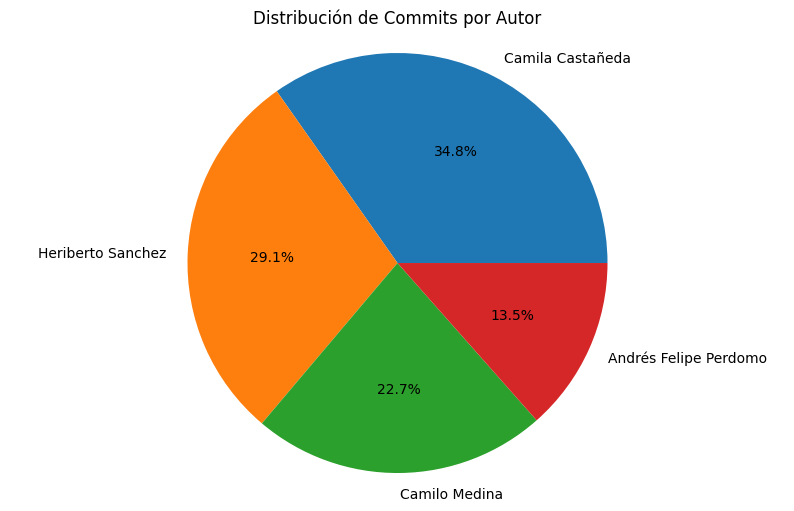

<Figure size 1200x600 with 0 Axes>

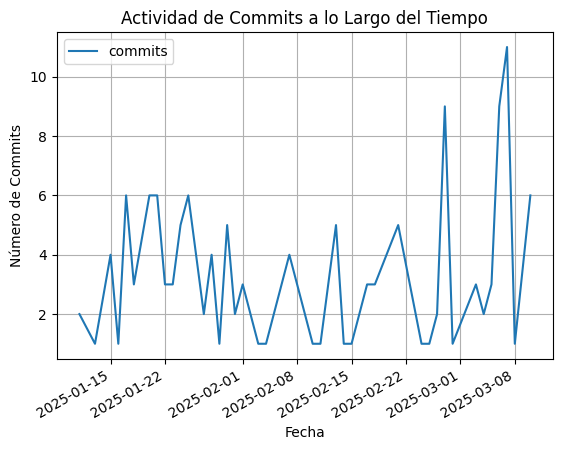

<Figure size 1000x600 with 0 Axes>

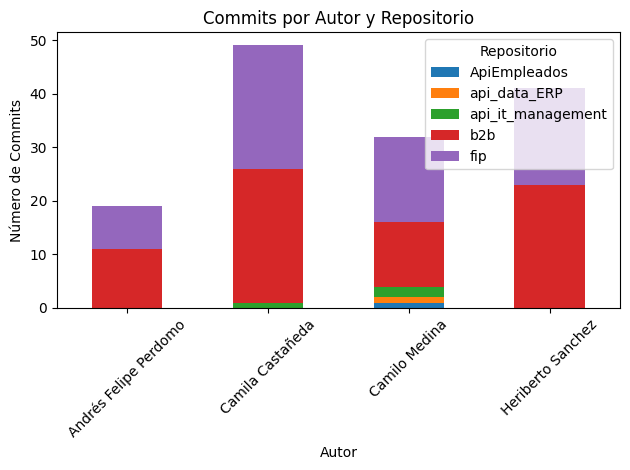

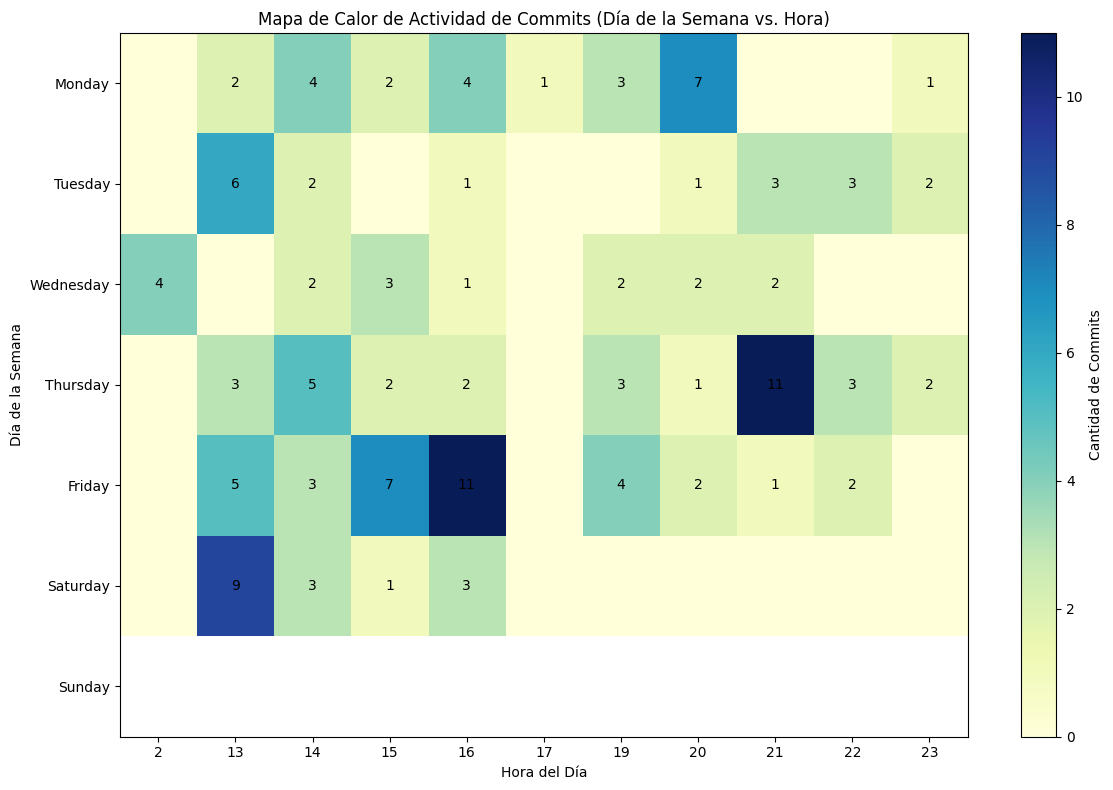


Perspectivas:
- Período de análisis: 58 días (2025-01-11 a 2025-03-10)
- Colaborador más activo: Camila Castañeda con 49 commits (34.75% del total)
- Promedio de commits por día: 3.36
- El día más activo tuvo 11 commits
- Repositorio más activo: b2b con 71 commits
- Días sin actividad de commits: 17 (28.8% de los días)


In [741]:
# Mostrar las estadísticas resumidas
print("Análisis de Actividad de Commits")
print("=======================")
display(commit_stats)

# 1. Distribución de commits por autor (gráfica circular)
plt.figure(figsize=(10, 6))
plt.pie(commit_stats["total_commits"], labels=commit_stats["author"], autopct="%1.1f%%")
plt.title("Distribución de Commits por Autor")
plt.axis("equal")
plt.show()

# 2. Commits a lo largo del tiempo
plt.figure(figsize=(12, 6))
time_series = df_commits.groupby("day").size().reset_index(name="commits")
time_series.set_index("day", inplace=True)
time_series.plot()
plt.title("Actividad de Commits a lo Largo del Tiempo")
plt.xlabel("Fecha")
plt.ylabel("Número de Commits")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()

# 3. Commits por autor y repositorio
plt.figure(figsize=(10, 6))
repo_commits_plot = (
    df_commits.groupby(["author", "repository"]).size().unstack().fillna(0)
)
repo_commits_plot.plot(kind="bar", stacked=True)
plt.title("Commits por Autor y Repositorio")
plt.xlabel("Autor")
plt.ylabel("Número de Commits")
plt.legend(title="Repositorio")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Mapa de calor de actividad diaria (día de la semana vs. hora del día)
df_commits["day_of_week"] = df_commits["date"].dt.day_name()
df_commits["hour"] = df_commits["date"].dt.hour

day_hour = df_commits.groupby(["day_of_week", "hour"]).size().unstack().fillna(0)
# Reordenar días
day_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_hour = day_hour.reindex(day_order)

plt.figure(figsize=(12, 8))
if has_seaborn:
    sns.heatmap(day_hour, cmap="YlGnBu", annot=True, fmt="g")
else:
    # Mapa de calor alternativo usando matplotlib
    plt.imshow(day_hour, cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="Cantidad de Commits")

    # Agregar anotaciones
    for i in range(day_hour.shape[0]):
        for j in range(day_hour.shape[1]):
            if not pd.isna(day_hour.iloc[i, j]) and day_hour.iloc[i, j] > 0:
                plt.text(
                    j,
                    i,
                    int(day_hour.iloc[i, j]),
                    ha="center",
                    va="center",
                    color="black",
                )

    plt.yticks(range(len(day_hour.index)), day_hour.index)
    plt.xticks(range(len(day_hour.columns)), day_hour.columns)

plt.title("Mapa de Calor de Actividad de Commits (Día de la Semana vs. Hora)")
plt.xlabel("Hora del Día")
plt.ylabel("Día de la Semana")
plt.tight_layout()
plt.show()

# Resumen de perspectivas
recent_date = df_commits["date"].max()
oldest_date = df_commits["date"].min()
analysis_period = (recent_date - oldest_date).days

print("\nPerspectivas:")
print(
    f"- Período de análisis: {analysis_period} días ({oldest_date.date()} a {recent_date.date()})"
)
print(
    f"- Colaborador más activo: {commit_stats['author'].iloc[0]} con {commit_stats['total_commits'].iloc[0]} commits ({commit_stats['percentage'].iloc[0]}% del total)"
)
print(f"- Promedio de commits por día: {df_commits.groupby('day').size().mean():.2f}")
print(f"- El día más activo tuvo {df_commits.groupby('day').size().max()} commits")

# Repositorio con más actividad
repo_activity = df_commits.groupby("repository").size().reset_index(name="commits")
most_active_repo = repo_activity.sort_values("commits", ascending=False).iloc[0]
print(
    f"- Repositorio más activo: {most_active_repo['repository']} con {most_active_repo['commits']} commits"
)

# Calcular días sin commits
all_days = pd.date_range(start=oldest_date.date(), end=recent_date.date())
commit_days = df_commits["day"].unique()
days_no_commits = len(all_days) - len(commit_days)
print(
    f"- Días sin actividad de commits: {days_no_commits} ({days_no_commits / len(all_days) * 100:.1f}% de los días)"
)

### Tamaño de los Commits

C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_34512\3594184337.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_commits['has_emoji_prefix'] = df_commits['message'].str.contains(pattern, regex=True)
C:\Users\DESARROLLADOR ERP\AppData\Local\Temp\ipykernel_34512\3594184337.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_by_author = df_commits.groupby(['author', 'size_category']).size().unstack().fillna(0)


<Figure size 1200x600 with 0 Axes>

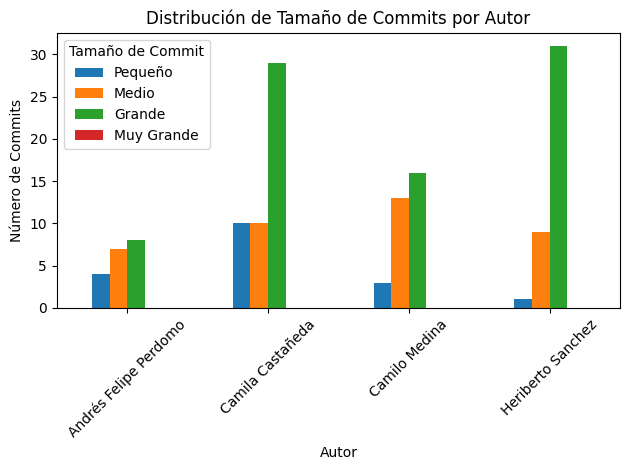

<Figure size 1200x600 with 0 Axes>

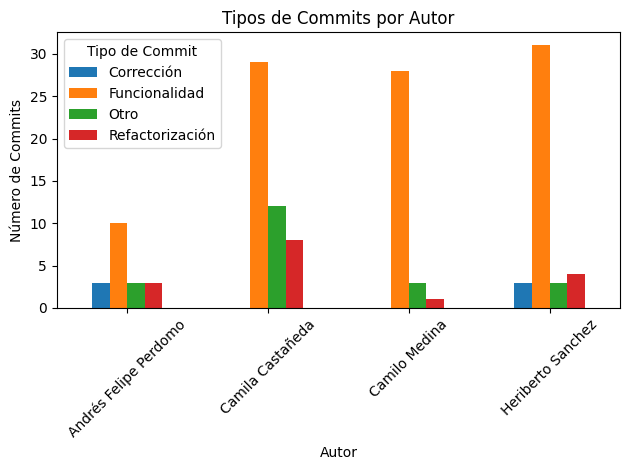


Resumen del Tamaño de Commits:
size_category          Pequeño  Medio  Grande  Muy Grande
author                                                   
Andrés Felipe Perdomo        4      7       8           0
Camila Castañeda            10     10      29           0
Camilo Medina                3     13      16           0
Heriberto Sanchez            1      9      31           0

Distribución por Tipo de Commit:
commit_type            Corrección  Funcionalidad  Otro  Refactorización
author                                                                 
Andrés Felipe Perdomo         3.0           10.0   3.0              3.0
Camila Castañeda              0.0           29.0  12.0              8.0
Camilo Medina                 0.0           28.0   3.0              1.0
Heriberto Sanchez             3.0           31.0   3.0              4.0

Longitud media de mensaje de commit: 139.3 caracteres
Desviación estándar: 55.9 caracteres
Umbral para commits grandes: 251.1 caracteres

Commits potenci

In [742]:
# Extender el análisis de commits para incluir tamaño (líneas agregadas/eliminadas)

# Verificar si las columnas necesarias existen en df_commits
if 'message' not in df_commits.columns:
    print("La columna 'message' no está disponible para analizar el contenido de los commits")
    # Podríamos intentar obtener estos datos con solicitudes adicionales

# Crear categorías de tamaño basadas en heurísticas
# 1. Extraer información del tamaño de los mensajes (como aproximación)
df_commits['msg_length'] = df_commits['message'].str.len()
    
# 2. Clasificar los commits por tamaño estimado basado en el mensaje
df_commits['size_category'] = pd.cut(
    df_commits['msg_length'], 
    bins=[0, 50, 150, 500, float('inf')],
    labels=['Pequeño', 'Medio', 'Grande', 'Muy Grande']
)

# 3. Analizar el tipo de commit basado en prefijos comunes
pattern = r'^(🐞|🧪|🚀|✅|🔧|📝)'
df_commits['has_emoji_prefix'] = df_commits['message'].str.contains(pattern, regex=True)
df_commits['commit_type'] = 'Otro'
df_commits.loc[df_commits['message'].str.contains(r'(?i)fix|🐞', na=False), 'commit_type'] = 'Corrección'
df_commits.loc[df_commits['message'].str.contains(r'(?i)feat|🧪', na=False), 'commit_type'] = 'Funcionalidad'
df_commits.loc[df_commits['message'].str.contains(r'(?i)refactor|🚀', na=False), 'commit_type'] = 'Refactorización'
df_commits.loc[df_commits['message'].str.contains(r'(?i)docs|📝', na=False), 'commit_type'] = 'Documentación'

# 4. Analizar patrones de commits por autor
size_by_author = df_commits.groupby(['author', 'size_category']).size().unstack().fillna(0)
type_by_author = df_commits.groupby(['author', 'commit_type']).size().unstack().fillna(0)

# 5. Visualización de los resultados
plt.figure(figsize=(12, 6))
ax = size_by_author.plot(kind='bar', stacked=False)
plt.title('Distribución de Tamaño de Commits por Autor')
plt.xlabel('Autor')
plt.ylabel('Número de Commits')
plt.xticks(rotation=45)
plt.legend(title='Tamaño de Commit')
plt.tight_layout()
plt.show()

# 6. Distribución de tipos de commits
plt.figure(figsize=(12, 6))
ax = type_by_author.plot(kind='bar', stacked=False)
plt.title('Tipos de Commits por Autor')
plt.xlabel('Autor')
plt.ylabel('Número de Commits')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Commit')
plt.tight_layout()
plt.show()

# 7. Resumen estadístico
print("\nResumen del Tamaño de Commits:")
print(size_by_author.to_string())
print("\nDistribución por Tipo de Commit:")
print(type_by_author.to_string())

# 8. Identificar commits extremadamente grandes o pequeños
avg_length = df_commits['msg_length'].mean()
std_length = df_commits['msg_length'].std()
large_threshold = avg_length + 2 * std_length

print(f"\nLongitud media de mensaje de commit: {avg_length:.1f} caracteres")
print(f"Desviación estándar: {std_length:.1f} caracteres")
print(f"Umbral para commits grandes: {large_threshold:.1f} caracteres\n")

# Commits muy grandes (mensaje extenso puede indicar muchos cambios)
large_commits = df_commits[df_commits['msg_length'] > large_threshold].sort_values(by='msg_length', ascending=False)
if not large_commits.empty:
    print("Commits potencialmente grandes:")
    for _, row in large_commits.head(5).iterrows():
        print(f"- Autor: {row['author']}, Mensaje: {row['message'][:50]}... ({row['msg_length']} caracteres)")

### Pull Requests (PR)

In [ ]:
import pandas as pd
from datetime import datetime

# Análisis de Pull Requests
import matplotlib.pyplot as plt

# Verificar los estados disponibles en los PRs
pr_states = df_pr["state"].value_counts().reset_index()
pr_states.columns = ["Estado", "Cantidad"]

# Analizar PR por autor
pr_by_author = df_pr.groupby(["author", "state"]).size().unstack().fillna(0)
if "MERGED" in pr_by_author.columns:
    pr_by_author["total"] = pr_by_author.sum(axis=1)
    pr_by_author = pr_by_author.sort_values("total", ascending=False)
    pr_by_author = pr_by_author.drop(columns=["total"])

# Calcular tiempos promedio
df_pr["created_on"] = pd.to_datetime(df_pr["created_on"])
df_pr["updated_on"] = pd.to_datetime(df_pr["updated_on"])

# Métricas de tiempo para PRs cerrados/mergeados
merged_prs = df_pr[df_pr["state"] == "MERGED"].copy()
if not merged_prs.empty:
    merged_prs["time_to_merge_days"] = (
        merged_prs["updated_on"] - merged_prs["created_on"]
    ).dt.total_seconds() / 86400
    avg_merge_time = merged_prs["time_to_merge_days"].mean()
    median_merge_time = merged_prs["time_to_merge_days"].median()
    max_merge_time = merged_prs["time_to_merge_days"].max()

# Extraer tipos de ramas de los PRs
branch_types = df_pr["type_branch"].value_counts().reset_index()
branch_types.columns = ["Tipo", "Cantidad"]

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Estado de los PRs
axes[0, 0].bar(pr_states["Estado"], pr_states["Cantidad"], color="skyblue")
axes[0, 0].set_title("Estado de Pull Requests")
axes[0, 0].set_xlabel("Estado")
axes[0, 0].set_ylabel("Cantidad")

# 2. PRs por autor
pr_by_author.plot(kind="bar", stacked=True, ax=axes[0, 1])
axes[0, 1].set_title("Pull Requests por Autor")
axes[0, 1].set_xlabel("Autor")
axes[0, 1].set_ylabel("Cantidad")
axes[0, 1].legend(title="Estado")

# 3. Tiempo de resolución de PRs
if not merged_prs.empty:
    merged_prs.boxplot(column="time_to_merge_days", ax=axes[1, 0])
    axes[1, 0].set_title("Tiempo para Merge (días)")
    axes[1, 0].set_ylabel("Días")

    # Añadir una línea para el promedio
    axes[1, 0].axhline(
        y=avg_merge_time,
        color="red",
        linestyle="-",
        label=f"Promedio: {avg_merge_time:.1f} días",
    )
    axes[1, 0].legend()

# 4. Tipos de ramas
axes[1, 1].pie(branch_types["Cantidad"], labels=branch_types["Tipo"], autopct="%1.1f%%")
axes[1, 1].set_title("Distribución de Tipos de Ramas")

plt.tight_layout()
plt.show()

# Métricas adicionales
print("\n=== Métricas de Pull Requests ===")
print(f"Total de PRs analizados: {len(df_pr)}")
print(f"PRs por estado: {dict(pr_states.values)}")
if not merged_prs.empty:
    print(f"\nTiempo promedio hasta merge: {avg_merge_time:.1f} días")
    print(f"Tiempo mediano hasta merge: {median_merge_time:.1f} días")
    print(f"Tiempo máximo hasta merge: {max_merge_time:.1f} días")

# Identificar PRs con tiempos de revisión largos y comentarios numerosos
if "comment_count" in df_pr.columns:
    high_discussion = df_pr.sort_values("comment_count", ascending=False).head(5)
    print("\n=== PRs con más discusión (mayor número de comentarios) ===")
    for _, row in high_discussion.iterrows():
        print(
            f"- {row['title']} | Autor: {row['author']} | Comentarios: {row['comment_count']} | Estado: {row['state']}"
        )

# Estadísticas de eficiencia por autor
if not merged_prs.empty:
    author_efficiency = (
        merged_prs.groupby("author")["time_to_merge_days"]
        .agg(["mean", "count"])
        .sort_values("mean")
    )
    print("\n=== Eficiencia de autores (tiempo promedio hasta merge) ===")
    for author, data in author_efficiency.iterrows():
        print(
            f"- {author}: {data['mean']:.1f} días promedio ({data['count']} PRs mergeados)"
        )

### Revisión de Código

### Tiempo de Revisión

### Actividad en Ramas

### Frecuencia de Merges

### Contribución a la Colaboración

### Integración con Otras Herramientas